In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Load Lagrangian data
root_dir = '/home1/datawork/zcaspar/mit4320/'
#'/home/datawork-lops-osi/equinox/mit4320/diags/'
run_name = 'regional_poly/'

#run_name_old = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'llc_parcels_filtered_itide_Tw30_sd_band04' #_iprime
#'filtered_itide_Tw30_sd_band04'

df = dd.read_parquet(root_dir+run_name+parcels_index)

df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag
time,,,,,,,,,,,,,,,
2011-11-15,35001007,-17.303181,-137.187500,0.0,0.0,0.0,0.0,-0.000026,0.026816,-0.000026,0.026816,0.002149,0.026127,0.002149,0.026127
2011-11-15,35000910,-14.537541,-141.354172,0.0,0.0,0.0,0.0,0.049445,-0.021093,0.049445,-0.021093,-0.020509,0.000604,-0.020509,0.000604
2011-11-15,35001215,-9.846332,-128.854172,0.0,0.0,0.0,0.0,-0.001417,-0.018067,-0.001417,-0.018067,-0.005595,-0.005669,-0.005595,-0.005669
2011-11-15,35001133,-16.385839,-131.979172,0.0,0.0,0.0,0.0,0.039953,-0.026825,0.039953,-0.026825,-0.023620,0.013761,-0.023620,0.013761
2011-11-15,35001146,-4.113701,-131.979172,0.0,0.0,0.0,0.0,-0.005542,0.012371,-0.005542,0.012371,0.030810,-0.017942,0.030810,-0.017942


In [12]:
df = df.compute()

In [13]:
dfi = df.loc['2011-11':'2012-09']

In [4]:
import os

#Eulerian
out_dir = os.path.join(root_dir, "regional_poly")#os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_eq_atl")
llc_zarr = os.path.join(out_dir, "llc_SSU.zarr")
llc_zarr_filt = os.path.join(out_dir, "llc_SSU_bfiltered.zarr")
llc_zarr_lfilt = os.path.join(out_dir, "llc_SSU_lfiltered.zarr")
ds = xr.open_zarr(llc_zarr).compute()
ds_low = xr.open_zarr(llc_zarr_lfilt).compute()
ds_hf = xr.open_zarr(llc_zarr_filt).compute()

In [9]:
ds_low

<xarray.Dataset>
Dimensions:      (j: 480, i: 135, time: 2880)
Coordinates:
    face         int64 8
  * i            (i) int64 1244 1248 1252 1256 1260 ... 1764 1768 1772 1776 1780
  * j            (j) int64 2304 2308 2312 2316 2320 ... 4204 4208 4212 4216 4220
  * time         (time) datetime64[ns] 2011-11-15 ... 2012-11-08T21:00:00
Data variables:
    SSU_rot_hat  (j, i, time) float64 -0.01785 -0.01589 ... -0.1139 -0.1139
    lat          (j, i) float64 -10.06 -10.14 -10.22 ... -19.84 -19.91 -19.98
    lon          (j, i) float64 -170.0 -170.0 -170.0 ... -130.1 -130.1 -130.1

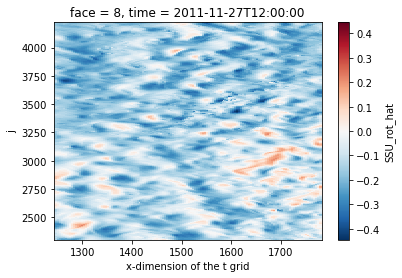

In [10]:
ds_low.SSU_rot_hat.isel(time=100).plot()

In [5]:
dim_lon = 'j'
dim_lat = 'i'

In [6]:
ds_low = ds_low.assign_coords({'lon':ds_low.lon.mean(dim_lat),'lat':ds_low.lat.mean(dim_lon)})
ds_hf = ds_hf.assign_coords({'lon':ds_hf.lon.mean(dim_lat),'lat':ds_hf.lat.mean(dim_lon)})
ds = ds.assign_coords({'lon':ds.lon.mean(dim_lat),'lat':ds.lat.mean(dim_lon)})

In [7]:
ds_low = ds_low.swap_dims({dim_lon:'lon',dim_lat:'lat'})
ds_hf = ds_hf.swap_dims({dim_lon:'lon',dim_lat:'lat'})
ds = ds.swap_dims({dim_lon:'lon',dim_lat:'lat'})

In [8]:
ds_low = ds_low.sel(time=slice('2011-11','2012-09'))
ds_hf = ds_hf.sel(time=slice('2011-11','2012-09'))
ds = ds.sel(time=slice('2011-11','2012-09'))

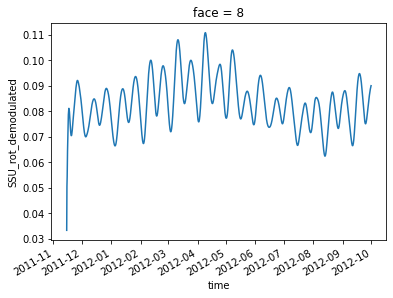

In [10]:
np.abs(ds_hf.SSU_rot_demodulated).mean(['lon','lat']).plot()

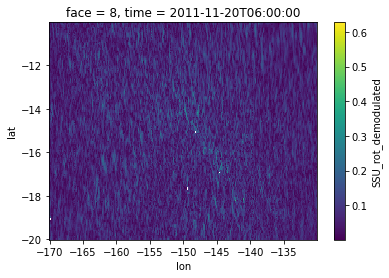

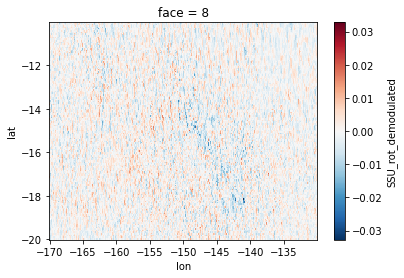

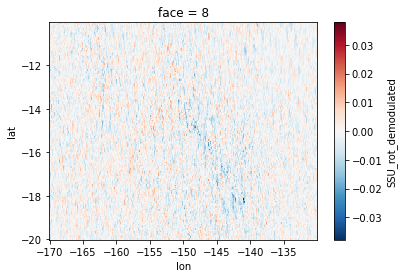

In [11]:
np.abs(ds_hf.SSU_rot_demodulated).sel(time='2011-11-20T06:00:00').plot(y='lat')
plt.figure()
(np.abs(ds_hf.SSU_rot_demodulated).sel(time='2011-11-20T00:00:00')-np.abs(ds_hf.SSU_rot_demodulated).sel(time='2011-11-20T06:00:00')).plot(y='lat')

plt.figure()
(np.abs(ds_hf.SSU_rot_demodulated).sel(time='2011-11-20T06:00:00')-np.abs(ds_hf.SSU_rot_demodulated).sel(time='2011-11-20T12:00:00')).plot(y='lat')

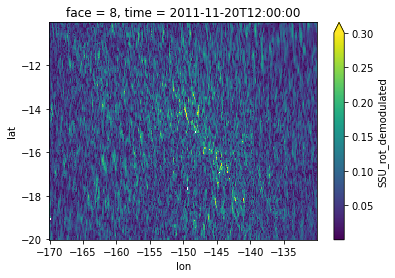

In [14]:
np.abs(ds_hf.SSU_rot_demodulated).sel(time='2011-11-20T12:00:00').plot(y='lat',vmax=0.3)

In [14]:
ds_low['energy_SSU_hat'] = ds_low.SSU_rot_hat**2
#ds_low['energy_SSV_hat'] = ds_low.SSV_rot_hat**2

In [14]:
v='SSU_rot'
def gen_figs(it,v,savefig=False):
    name=v+'_%s'%it
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    ds_low[v+'_hat'].isel(time=it).plot(ax=ax[1],x='lon',y='lat',vmax=0.4,vmin=-0.4,cmap='RdBu_r',
                                                        cbar_kwargs={'label':'Low pass filtered : '+v})
    np.abs(ds_hf[v+'_demodulated']).isel(time=it).plot(ax=ax[2],x='lon',y='lat',vmax=0.3,vmin=0,cmap='Reds',
                                                        cbar_kwargs={'label':'Band pass filtered + demodulation : '+v})
    ds[v].isel(time=it).plot(ax=ax[0],x='lon',y='lat',vmax=0.4,vmin=-0.4,cmap='RdBu_r')
    for a in ax:
        a.set_title('Time : %s'%ds[v].isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/raw_lpass_bpass/'+name+'.jpg')
        plt.close()

In [ ]:
for it in range(0,ds_low.time.size,2):
    gen_figs(it,v,savefig=True)

#gen_figs(ds_low,100,'SSV_rot')

In [43]:
_df = df[['trajectory','lat','lon','zonal_velocity_demodulated_real','meridional_velocity_demodulated_real']]

In [44]:
time = np.unique(_df.index)

In [45]:
_df_sub = _df.loc[time[::3]]

In [46]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [47]:
_df_sub = _df_sub.reset_index().groupby('trajectory').apply(remove_duplicates)

In [48]:
_df_sub = _df_sub.drop(columns = 'trajectory').reset_index().set_index('time')

In [49]:
_df_sub['energy_SSU'] = (_df_sub.zonal_velocity_hat_real)**2
_df_sub['energy_SSV'] = (_df_sub.meridional_velocity_hat_real)**2
_df_sub['energy_SSV_tot'] = (_df_sub.meridional_velocity)**2
_df_sub['energy_SSU_tot'] = (_df_sub.zonal_velocity)**2

AttributeError: 'DataFrame' object has no attribute 'zonal_velocity_hat_real'

In [50]:
np.unique(_df_sub.index).size
print(_df_sub.index[0],_df_sub.index[-1])
print(ds_low.time[0],ds_low.time[-1])

2011-11-15 00:00:00 2012-11-09 00:00:00
<xarray.DataArray 'time' ()>
array('2011-11-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 11
    time     datetime64[ns] 2011-11-15 <xarray.DataArray 'time' ()>
array('2012-09-30T21:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 11
    time     datetime64[ns] 2012-09-30T21:00:00


In [51]:
_df_sub

,trajectory,lat,lon,zonal_velocity_demodulated_real,meridional_velocity_demodulated_real
time,,,,,
2011-11-15 00:00:00,6000055,2.069601,-32.770832,1.602993e-02,-0.040980
2011-11-15 03:00:00,6000055,2.038908,-32.793672,1.410394e-02,-0.045184
2011-11-15 06:00:00,6000055,2.003145,-32.829403,1.782084e-02,-0.048580
2011-11-15 09:00:00,6000055,1.976769,-32.856139,2.006428e-02,-0.051562
2011-11-15 12:00:00,6000055,1.950420,-32.886416,2.010332e-02,-0.055005
...,...,...,...,...,...
2012-11-08 12:00:00,46003276,9.944595,-81.525653,-1.222600e-06,0.000002
2012-11-08 15:00:00,46003276,9.918916,-81.468471,-3.996900e-07,0.000002
2012-11-08 18:00:00,46003276,9.891807,-81.412802,1.790451e-06,-0.000004


In [71]:
def gen_fig_flts(it,v,savefig=False):
    name=v+'_%s'%it
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    (np.abs(ds_hf[v+'_demodulated'])**2).isel(time=it).plot(ax=ax,x='lon',y='lat',vmax=0.05,vmin=0,cmap='OrRd',
                                                        cbar_kwargs={'label':'Low pass filtered'+v})
    time = np.unique(df.index)
    _df = df.loc[time[it]]
    ax.scatter(_df.lon,_df.lat,c='k',s=2)
#    ax.scatter(df_id.lon,df_id.lat)
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax)
#    ax.set_xlim(ds_low.lon.min(),ds_low.lon.max());ax.set_ylim(ds_low.lat.min(),ds_low.lat.max())
    ax.set_title('Time : %s'%ds_low.isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/flts_bpass/'+name+'.jpg')
        plt.close()

In [60]:
time_sub = np.unique(_df_sub.index)

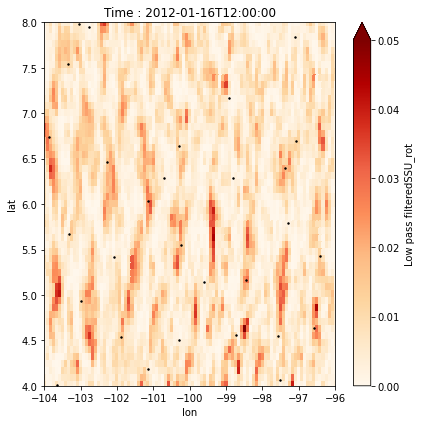

In [77]:
it = 500
latmin,latmax = 4,8
lonmin,lonmax = -104, -96
gen_fig_flts(it,'SSU_rot',savefig=False)

#plt.figure()
#(np.abs(ds_hf[v+'_demodulated'])**2).mean('time').plot(x='lon',y='lat',vmax=0.1,vmin=0,cmap='OrRd')

In [78]:
for it in range(0,ds_hf.time.size,2):
    gen_fig_flts(it,'SSU_rot',savefig=True)

In [28]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/